In [29]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,Average_Price,Money_Flow,Pos_Flow,Neg_Flow,MFI,BB_SMA,BB_STD,Upper_Band,Lower_Band,MFI_Strategy,BB_Strategy,Full_Strategy,Strategy,Asset_Returns,Strategy_Returns
32,158.710007,174.654999,158.220001,174.449997,279700,163.861669,4.583211e+07,0.000000,163.861669,71.990820,140.249000,17.839278,158.088278,122.409722,NaN,NaN,NaN,0,NaN,NaN
33,160.089996,166.460007,159.000000,159.000000,310400,161.850001,5.023824e+07,0.000000,161.850001,64.572393,141.503500,18.326275,159.829775,123.177224,-1.0,-1.0,-2.0,-1,0.008695,-0.008695
34,160.289993,164.160004,158.600006,161.330002,303700,161.016668,4.890076e+07,0.000000,161.016668,57.405146,142.843999,18.685502,161.529502,124.158497,0.0,-1.0,-1.0,0,0.009955,-0.008695
35,185.000000,185.850006,158.000000,158.570007,437400,176.283335,7.710633e+07,176.283335,0.000000,64.209788,145.518999,20.697243,166.216242,124.821757,0.0,0.0,0.0,0,0.165648,-0.008695
36,184.979996,191.500000,183.050003,185.199997,697700,186.510000,1.301280e+08,186.510000,0.000000,70.728494,148.459999,21.943170,170.403169,126.516829,0.0,-1.0,-1.0,0,0.165522,-0.008695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
958,514.299988,531.940002,510.720001,522.770020,840800,518.986664,4.363640e+08,0.000000,518.986664,63.861131,475.428999,61.905421,537.334420,413.523578,-1.0,0.0,-1.0,0,2.240501,-0.225896
959,517.799988,526.299988,510.981995,511.109985,537900,518.360657,2.788262e+08,0.000000,518.360657,56.923848,482.567999,57.814297,540.382297,424.753702,0.0,0.0,0.0,0,2.262554,-0.225896
960,520.210022,524.414978,510.000000,512.309998,459400,518.208333,2.380649e+08,0.000000,518.208333,49.927043,489.487001,53.221825,542.708826,436.265176,0.0,0.0,0.0,0,2.277739,-0.225896
961,525.000000,529.770020,512.099976,528.023987,524000,522.289998,2.736800e+08,522.289998,0.000000,56.854427,496.520001,47.591855,544.111856,448.928146,0.0,0.0,0.0,0,2.307920,-0.225896


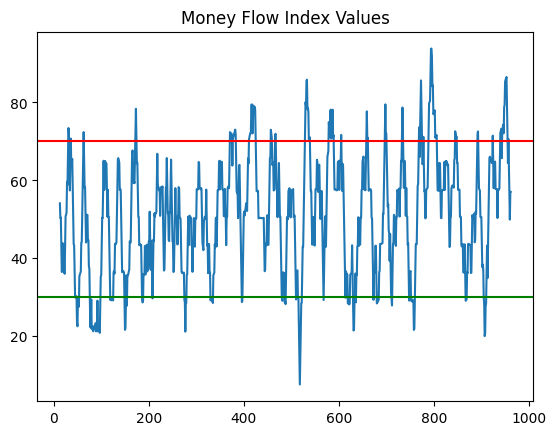

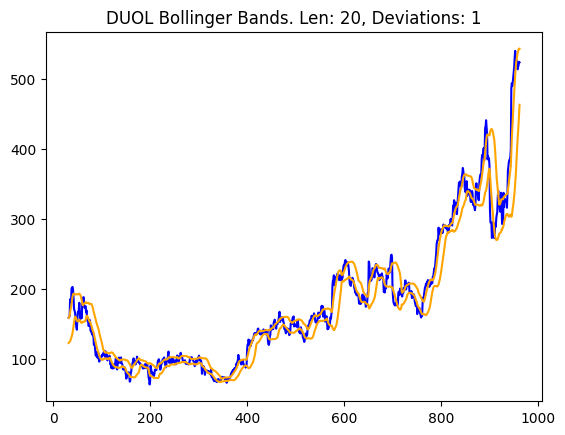

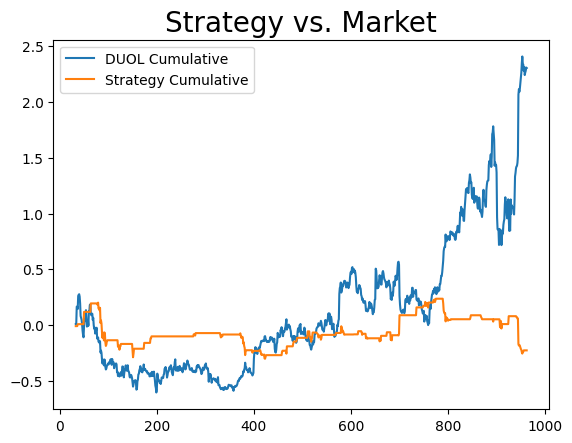

In [30]:
TICKER = 'DUOL'
INTERVAL='1d'

# set period based on interval
if INTERVAL == '1h':
    PERIOD = '730d'
else:
    PERIOD = 'max'

MFI_LENGTH = 14
OVERBOUGHT = 70
OVERSOLD = 30
BB_LEN = 20
DEVS = 1


# what subsetion of that data are you interested in
LOOKBACK = 10000

def get_data(ticker=TICKER, lookback=LOOKBACK, interval=INTERVAL):

    # get data at interval you want
    df = yf.download(ticker, interval=interval, period=PERIOD)
    df.columns = df.columns.get_level_values(0)

    # reset the index to make plots prettier
    df = df.reset_index(drop=True)

    # only return the subset of data you are interested in
    return df.iloc[-lookback:, :]

def add_MFI(df, length=MFI_LENGTH):

    df['Average_Price'] = (df['High'] + df['Low'] + df['Close']) / 3
    df['Money_Flow'] = df['Volume'] * df['Average_Price']
 
    # initialize empty flows
    df['Pos_Flow'] = 0
    df['Neg_Flow'] = 0

    df['Pos_Flow'] = np.where(df['Average_Price'].diff() > 0, df['Average_Price'], 0)
    df['Neg_Flow'] = np.where(df['Average_Price'].diff() < 0, df['Average_Price'], 0)

    mfr = df['Pos_Flow'].rolling(length).sum() / df['Neg_Flow'].rolling(length).sum()

    # add money flow column
    df['MFI'] = 100 - (100 / (1 + mfr))

    plt.figure()
    plt.plot(df['MFI'])
    plt.axhline(OVERBOUGHT, color='red')
    plt.axhline(OVERSOLD, color='green')
    plt.title('Money Flow Index Values');
        
    return df.dropna()

def add_MFI_strategy(df, overbought=OVERBOUGHT, oversold=OVERSOLD):

    df['MFI_Strategy'] = 0
    df['MFI_Strategy'] = np.where(df['MFI'] > overbought, -1, 
                     np.where(df['MFI'] < oversold, 1, 0))
    
    # shift back to make sure we have seen the signal
    df['MFI_Strategy'] = df['MFI_Strategy'].shift(1)
    return df

def add_BB(df, devs=DEVS, bb_len=BB_LEN):

    # can change to ema (use MACD video/code for reference)
    df['BB_SMA'] = df['Close'].rolling(bb_len).mean()

    # get the standard deviation of the close prices for the period
    df['BB_STD'] = df['Close'].rolling(bb_len).std()

    df['Upper_Band'] = df['BB_SMA'] + (devs * df['BB_STD'])
    df['Lower_Band'] = df['BB_SMA'] - (devs * df['BB_STD'])

    df = df.dropna()

    plt.figure()
    plt.plot(df['Close'], color='blue')
    plt.plot(df['Upper_Band'], color='orange')
    plt.plot(df['Lower_Band'], color='orange')

    plt.title(f'{TICKER} Bollinger Bands. Len: {BB_LEN}, Deviations: {DEVS}');

    return df

def add_BB_strategy(df):
    df['BB_Strategy'] = 0
    df['BB_Strategy'] = np.where(
        df['Close'] > df['Upper_Band'], -1, 
        np.where(df['Close'] < df['Lower_Band'], 1, 0)
        )
    
    df['BB_Strategy'] = df['BB_Strategy'].shift(1)
    
    return df

def add_full_strategy(df):

    df['Full_Strategy'] = df['BB_Strategy'] + df['MFI_Strategy']

    # adjust values for simplicity
    df['Strategy'] = np.where(df['Full_Strategy'] == 2, 1, 
                     np.where(df['Full_Strategy'] == -2, -1, 0))

    return df

def test_strategy(df):

    df['Asset_Returns'] = (1 + df['Close'].pct_change()).cumprod() - 1
    df['Strategy_Returns'] = (1 + df['Close'].pct_change() * df['Strategy']).cumprod() -1

    plt.figure()
    plt.plot(df['Asset_Returns'])
    plt.plot(df['Strategy_Returns'])
    plt.legend([f'{TICKER} Cumulative', 'Strategy Cumulative'])
    plt.title('Strategy vs. Market', size='20')

    return df

def main():
    df = get_data()
    df = add_MFI(df)
    df = add_BB(df)
    df = add_MFI_strategy(df)
    df = add_BB_strategy(df)
    df = add_full_strategy(df)
    df = test_strategy(df)

    return df

df = main()
df